In [1]:
import json
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEBUG = True

In [3]:
dir_path = Path("bench_data")

data = []
# Iterate over all-algo files, they have no prefix and start with 0
for json_path in sorted(dir_path.glob("0*.json")):
    with open(json_path) as json_file:
        try:
            record = json.load(json_file)
        except json.JSONDecodeError:
            if DEBUG:
                continue
            else:
                raise
    
    # Iterate over algo-specific files corresponding to the given "main" file
    for algo in ['lsdb', 'astropy', 'smatch']:
        algo_path = dir_path / f'{algo}_{json_path.name}'
        if not algo_path.exists():
            continue
        with open(algo_path) as algo_file:
            try:
                algo_record = json.load(algo_file)
            except json.JSONDecodeError:
                if DEBUG:
                    continue
                else:
                    raise
        record['measurements'] |= algo_record['measurements']
            
    data.append(record)

In [4]:
lsdb_dict = defaultdict(list)
skycoord_dict = defaultdict(list)
astropy_dict = defaultdict(list)
smatch_dict = defaultdict(list)
xmatch_radius_arcsec_ = []
dask_n_workers_ = []
length_to_radius = {}

default_meas = {'time': np.nan, 'result_length': np.nan}

for record in data:
    result_length = record['measurements'].get('lsdb', default_meas)['result_length']
    dask_n_workers = record['args']['dask_n_workers']
    xmatch_radius_arcsec = record['args']['xmatch_radius_arcsec']
    cone_radius_deg = record['args']['cone_radius_deg']
    lsdb_time = record['measurements'].get('lsdb', default_meas)['time']
    skycoord_time = record['measurements'].get('init_skycoord', default_meas)['time']
    astropy_time = record['measurements'].get('astropy', default_meas)['time']
    smatch_time = record['measurements'].get('smatch', default_meas)['time']

    lsdb_key = (xmatch_radius_arcsec, dask_n_workers, result_length)
    astropy_key = (xmatch_radius_arcsec, result_length)
    smatch_key = (xmatch_radius_arcsec, result_length)

    lsdb_dict[lsdb_key].append(lsdb_time)
    skycoord_dict[astropy_key].append(skycoord_time)
    astropy_dict[astropy_key].append(astropy_time)
    smatch_dict[smatch_key].append(smatch_time)
    
    xmatch_radius_arcsec_.append(xmatch_radius_arcsec)
    dask_n_workers_.append(dask_n_workers)
    
    length_to_radius[result_length] = cone_radius_deg

lsdb_dict = {k: np.array(v) for k, v in lsdb_dict.items()}
skycoord_dict = {k: np.array(v) for k, v in skycoord_dict.items()}
astropy_dict = {k: np.array(v) for k, v in astropy_dict.items()}
smatch_dict = {k: np.array(v) for k, v in smatch_dict.items()}
xmatch_radius_arcsec_ = np.unique(xmatch_radius_arcsec_)
dask_n_workers_ = np.unique(dask_n_workers_)

/var/tmp/ipykernel_98345/4258610523.py:55: RuntimeWarning: All-NaN slice encountered
  time_median = np.array([np.nanmedian(t) for (r, _l), t in smatch_dict.items() if r == xmatch_radius_arcsec])
/ocean/projects/phy210048p/malanche/lsdb-xmatch-perf/cenv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


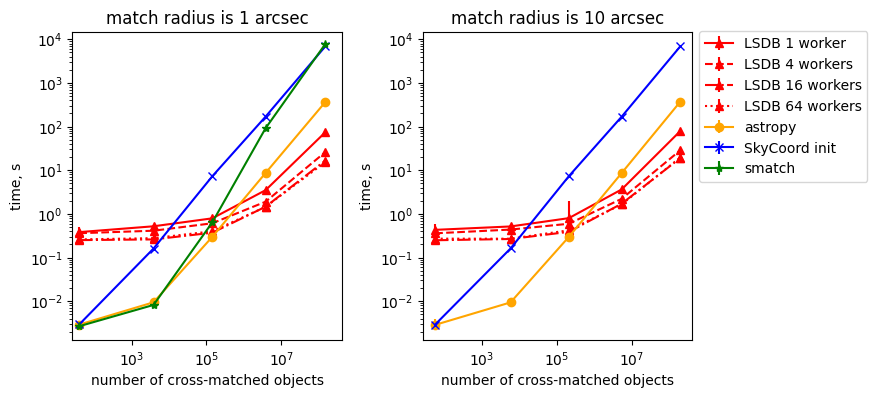

In [5]:
fig, axs = plt.subplots(1, len(xmatch_radius_arcsec_), figsize=(4 * len(xmatch_radius_arcsec_), 4))

# More horizontal space between panels
plt.subplots_adjust(wspace=0.3)

if not hasattr(axs, '__len__'):
    axs = [axs]

legend_dict = {}
    
for ax, xmatch_radius_arcsec in zip(axs, xmatch_radius_arcsec_):
    length = None
    for line_style, dask_n_workers in zip(['-', '--', '-.', ':'], dask_n_workers_):
        if length is None or DEBUG:
            length = [
                l
                for r, w, l in lsdb_dict.keys()
                if r == xmatch_radius_arcsec and w == dask_n_workers
            ]
            radius_deg = np.vectorize(length_to_radius.get)(length)
        time_median = np.array([
            np.nanmedian(t)
            for (r, w, _l), t in lsdb_dict.items()
            if r == xmatch_radius_arcsec and w == dask_n_workers
        ])
        time_q10, time_q90 = np.array([
            np.nanquantile(t, [0.1, 0.9])
            for (r, w, _l), t in lsdb_dict.items()
            if r == xmatch_radius_arcsec and w == dask_n_workers
        ]).T
        
        legend_dict[f'LSDB {dask_n_workers} worker{"s" if dask_n_workers > 1 else ""}'] = ax.errorbar(
            length, time_median, [time_median-time_q10, time_q90-time_median], ls=line_style, marker='^', color='r',
        )
    
    length = [l for r, l in astropy_dict.keys() if r == xmatch_radius_arcsec]
    time_median = np.array([np.nanmedian(t) for (r, _l), t in astropy_dict.items() if r == xmatch_radius_arcsec])
    time_q10, time_q90 = np.array([
        np.nanquantile(t, [0.1, 0.9])
        for (r, _l), t in astropy_dict.items()
        if r == xmatch_radius_arcsec
    ]).T
    legend_dict['astropy'] = ax.errorbar(length, time_median, [time_median-time_q10, time_q90-time_median], ls=None, marker='o', color='orange')
    
    length = [l for r, l in skycoord_dict.keys() if r == xmatch_radius_arcsec]
    time_median = np.array([np.nanmedian(t) for (r, _l), t in skycoord_dict.items() if r == xmatch_radius_arcsec])
    time_q10, time_q90 = np.array([
        np.nanquantile(t, [0.1, 0.9])
        for (r, _l), t in skycoord_dict.items()
        if r == xmatch_radius_arcsec
    ]).T
    legend_dict['SkyCoord init'] = ax.errorbar(length, time_median, [time_median-time_q10, time_q90-time_median], ls=None, marker='x', color='b')
    
    length = [l for r, l in smatch_dict.keys() if r == xmatch_radius_arcsec]
    time_median = np.array([np.nanmedian(t) for (r, _l), t in smatch_dict.items() if r == xmatch_radius_arcsec])
    time_q10, time_q90 = np.array([
        np.nanquantile(t, [0.1, 0.9])
        for (r, _l), t in smatch_dict.items()
        if r == xmatch_radius_arcsec
    ]).T
    legend_dict['smatch'] = ax.errorbar(length, time_median, [time_median-time_q10, time_q90-time_median], ls=None, marker='*', color='g')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('number of cross-matched objects')
    ax.set_ylabel('time, s')
    ax.set_title(f'match radius is {xmatch_radius_arcsec:.0f} arcsec')
    
    
for ax in axs:
    ax.set_xlim(axs[-1].get_xlim())
    ax.set_ylim(axs[-1].get_ylim())
    
fig.legend(legend_dict.values(), legend_dict.keys(), bbox_to_anchor=(0.9, 0.9), loc='upper left')